# Multivariate Normal Sampling (Brownian bridge), GP Regression( Seasonal Pattern; Over Plane )


## 1. Multivariate Normal Sampling (Brownian bridge)
Write code to generate a path of the Brownian bridge, sampled at the points $t_i=i/100,\;\; i=0,1,\ldots,100$. Note that your path should begin and end at zero, i.e. $X_0=X_1=0$. The following starter code shows how to generate a sample form a multivariate Normal in Python.


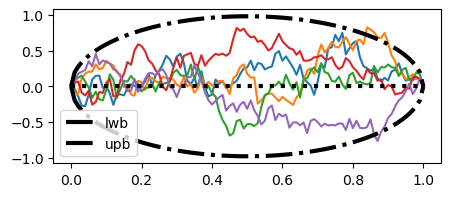

In [1]:
import numpy as np; import matplotlib.pyplot as plt

N = 101; t = np.linspace(0,1,N)
mean = np.zeros(N); cov = np.eye(N)

# define covariance matrix of Brownian bridge K(x,x') = min(x,x')-x*x'
for i in range(N):
    for j in range(N):
        cov[i,j] = min( t[i], t[j] ) - t[i] * t[j]

rng = np.random.default_rng()
X = rng.multivariate_normal( mean, cov, size = 1).reshape(-1,1)
plt.figure(figsize=(5, 2)); plt.plot(t, X)

# plot another 4 paths of the Brownian bridge proocess, together with 95% CI
X = rng.multivariate_normal( mean, cov, size = 4)
for i in range(4):
    plt.plot( t, X[i,:])
plt.plot( [0,1], [0,0] , 'k:', linewidth = 3)
plt.plot( t, -1.96 * np.sqrt( t*(1-t) ) , 'k-.', linewidth = 3, label='lwb')
plt.plot( t, +1.96 * np.sqrt( t*(1-t) ) , 'k-.', linewidth = 3, label='upb')
plt.legend(loc='lower left');

## 2. GP regression (seasonal pattern)

The following code loads and plots the monthly totals of international airline passengers, from 1949 to 1960. The data are transformed into a regression training set, where `x` is the (ordered) time index, and `y` is the logarithm of the total count. Note that there is a strong  seasonal pattern with a period of 12 months, as well as an increasing trend over time (linear in log-counts = exponential in raw counts). 

Read this [forecasting example](https://scikit-learn.org/1.5/auto_examples/gaussian_process/plot_gpr_co2.html#sphx-glr-auto-examples-gaussian-process-plot-gpr-co2-py) from `sklearn`, and adapt it to **make predictions/extrapolate** over the subsequent 5 years of data. Use a product kernel that multiplies a `DotProduct` kernel (for the linear trend) with an `ExpSineSquared` kernel (for the seasonal pattern) and a `ConstantKernel` for overall scaling, and then adds a `WhiteKernel` for the errors. Select the hyperparameters by optimizing the evidence, and plot the posterior predictive distribution of the fitted GP over the next 5 years, together with 95% confidence intervals.

#### 2.1. Load Data



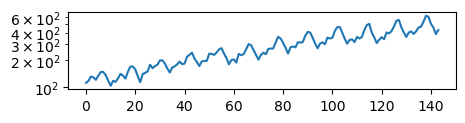

In [2]:
import numpy as np; import matplotlib.pyplot as plt; import seaborn as sns

flights = sns.load_dataset("flights")
flights['time'] = flights.index
x = np.array( flights.index.tolist() ).reshape(-1,1)
y = np.array( np.log( flights['passengers'].tolist() ) ).reshape(-1,1)

plt.figure(figsize=(5, 1)); plt.plot(x, np.exp(y)); plt.yscale('log')

#### 2.2. Fit & Prediction

Prior kernel: 1**2 * DotProduct(sigma_0=1) * ExpSineSquared(length_scale=1, periodicity=12) + WhiteKernel(noise_level=0.1)
Optimazed/posterior kernel 0.00514**2 * DotProduct(sigma_0=653) * ExpSineSquared(length_scale=2.13, periodicity=12) + WhiteKernel(noise_level=0.00328)


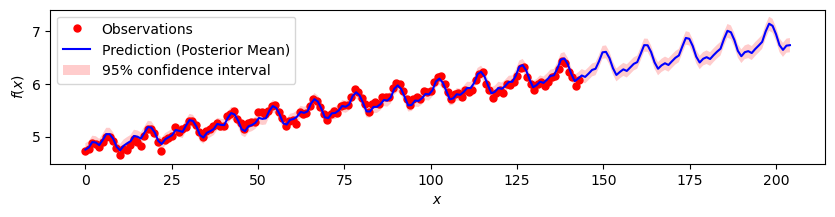

In [3]:
import numpy as np; import matplotlib.pyplot as plt;from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, ConstantKernel as C, ExpSineSquared as ESS, WhiteKernel as WK

# Kernel define & fit gp 
kernel = C(1) * DotProduct(1) * ESS( length_scale = 1, periodicity = 12, periodicity_bounds="fixed") + WK(.1)
print("Prior kernel:",kernel)
gp = GaussianProcessRegressor( kernel, n_restarts_optimizer=100) 
gp.fit(x,y)
print("Optimazed/posterior kernel", gp.kernel_) # prints the optimazed kernel hyperparameters 

# Prediction points
x_pred = np.linspace(0, x.shape[0]+5*12, x.shape[0]+5*12).reshape(-1, 1)
y_pred, sigma = gp.predict(x_pred, return_std=True)
    
# Plot the results
plt.figure(figsize=(10, 2));
plt.plot(x, y, 'r.',markersize=10,label='Observations'); plt.plot(x_pred, y_pred,'b-',label='Prediction (Posterior Mean)')
plt.fill(np.concatenate([x_pred, x_pred[::-1]]),np.concatenate([y_pred - 1.9600 * sigma, (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.2, fc='r', ec='None', label='95% confidence interval')
plt.xlabel('$x$'); plt.ylabel('$f(x)$'); plt.legend(loc='upper left')


## 3. GP regression over plane: RBF ( different length-scales)
For this question you will practice GP regresion over the plane, i.e., for random functions $\{f(\mathbf{x}), \;\; \mathbf{x} \in \mathbb{R}^2\}$. The following code samples and plots such a 2D function/surface. 

Note that the process employs an RBF kernel with **different length-scales** across **different dimensions**: we have $\ell_{x_1}=5$ & $\ell_{x_2}=0.5$ which means that the function changes faster in the $x_2$-direction than it does in the $x_1$-direction.

$$
k(x, x') = \exp \left( -\frac{1}{2} \left( \frac{(x_1 - x_1')^2}{\ell_{x_1}^2} + \frac{(x_2 - x_2')^2}{\ell_{x_2}^2} \right) \right) = \exp \left( -\frac{1}{2} \left( \frac{(x_1 - x_1')^2}{5^2} + \frac{(x_2 - x_2')^2}{0.5^2} \right) \right)
$$

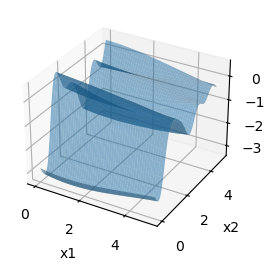

In [4]:
import numpy as np; from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

nv = 50  # Number of points in each direction
x1v = np.linspace( 0.0, 5.0, nv); x2v = np.linspace( 0.0, 5.0, nv)  # x1;x2-vector
x1, x2 = np.meshgrid(x1v, x2v)  # x1 and x2 are (nv, nv) matrices
X = np.column_stack((x1.reshape(-1), x2.reshape(-1))) # Convert to column vectors then combine

kernel = RBF( length_scale=( 5, 0.5 ) )  # define RBF kernel with difference length-scales
gp = GaussianProcessRegressor(kernel, normalize_y=False)  
Y = gp.sample_y( X ).reshape(x1.shape)

fig = plt.figure(figsize=(10, 3));ax = fig.add_subplot(111, projection='3d'); ax.plot_surface(x1, x2, Y, alpha=0.5)
ax.set_xlabel('x1');ax.set_ylabel('x2');plt.show();

### 3.1. Generate Data (randomNum) 
Modify this code to fit a 2D GP regression model to the data generated below. Use the 2D RBF kernel and remember to add the White noise kernel. Plot the posterior together with the data points.

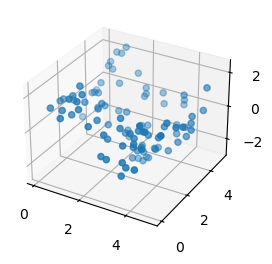

In [5]:
import numpy as np;
# Generate sample data
N=100
rng = np.random.RandomState(0)
X_train = rng.uniform(0, 5, size=(100, 2)) # Generates random num from uniform dist 0 to 5.

y_train = (np.sin(  0.5 * np.pi * X_train[:,0] ) + np.sin(  0.5 * np.pi * X_train[:,1] ) \
        + rng.normal(loc=0, scale=0.5, size=100)).reshape(-1,1)

fig = plt.figure(figsize=(10, 3)); ax = fig.add_subplot(111, projection='3d'); 
ax.scatter(X_train[:,0], X_train[:,1], y_train, label='Data')

### 3.2.  Regression model (2D GP) 

In [6]:
import numpy as np; from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel as WK

### trainData 
N=100; rng = np.random.RandomState(0); X_train = rng.uniform(0, 5, size=(100, 2))
y_train = (np.sin(  0.5 * np.pi * X_train[:,0] ) + np.sin(  0.5 * np.pi * X_train[:,1] ) \
        + rng.normal(loc=0, scale=0.5, size=100)).reshape(-1,1)

### 2D GP regression model, ConstantKernel * 2D RBF kernel + White noise kernel
kernel = C(1.0, (1e-3, 1e3)) * RBF( (1,1), ((1e-2, 1e2),)*2) + WK(1.0)
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
gp.fit(X_train, y_train )
print(gp.kernel_) 

1.41**2 * RBF(length_scale=[1.36, 1.38]) + WhiteKernel(noise_level=0.225)


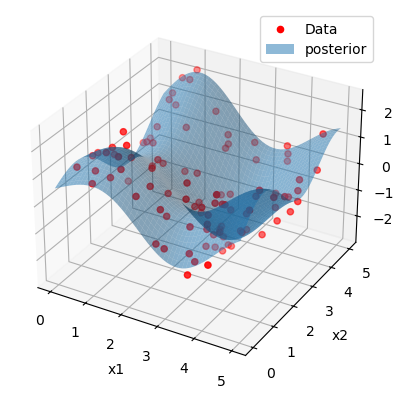

In [7]:
### predictData 
nv = 50  # Number of points in each direction
x1v = np.linspace( 0.0, 5.0, nv); x2v = np.linspace( 0.0, 5.0, nv)
x1, x2 = np.meshgrid(x1v, x2v)  # x1 and x2 are (nv, nv) matrices
X_pred = np.column_stack((x1.reshape(-1), x2.reshape(-1))) # Convert to column vectors then combine

### Prediction
Y_post = gp.predict( X_pred ).reshape(x1.shape)

### plot (posterior & data points)
import matplotlib.pyplot as plt
fig = plt.figure(); ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_train[:,0], X_train[:,1], y_train, color = 'r', label='Data')
ax.plot_surface(x1, x2, Y_post, alpha=0.5, label='posterior'); ax.set_xlabel('x1'); ax.set_ylabel('x2'); 
ax.legend(); plt.show();